In [1]:
import os
os.chdir("../../../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from keras import regularizers
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
target_dir = os.getcwd() + "/data/tourism/palau/intermediate/"
palau = pd.read_csv(target_dir + 'palau_merged.csv').drop("Unnamed: 0", axis=1)
palau.columns = [col.replace(" ", "_").lower() for col in palau.columns]
palau.head(5)

,year,month,seats_arrivals_intl,seats_arrivals_total,number_of_flights_intl,number_of_flights_total,date,japan,south_korea,taiwan,china,usa/canada,europe,others,total
0,2019,1,13048.0,13048.0,75.0,75.0,2019-01-01,1953.0,1169.0,919.0,2072.0,626.0,310.0,280.0,7329.0
1,2019,2,13281.0,13281.0,74.0,74.0,2019-02-01,2055.0,1035.0,1092.0,4059.0,702.0,438.0,371.0,9752.0
2,2019,3,12870.0,12870.0,73.0,73.0,2019-03-01,2434.0,1090.0,1190.0,2549.0,826.0,483.0,461.0,9033.0
3,2019,4,10806.0,10806.0,64.0,64.0,2019-04-01,1756.0,808.0,1099.0,3182.0,777.0,368.0,415.0,8405.0
4,2019,5,11472.0,11472.0,67.0,67.0,2019-05-01,1288.0,1095.0,1393.0,2489.0,607.0,185.0,421.0,7478.0


In [3]:
data = palau.drop(["date", "year", "month"], axis=1)
data.head(5)

,seats_arrivals_intl,seats_arrivals_total,number_of_flights_intl,number_of_flights_total,japan,south_korea,taiwan,china,usa/canada,europe,others,total
0,13048.0,13048.0,75.0,75.0,1953.0,1169.0,919.0,2072.0,626.0,310.0,280.0,7329.0
1,13281.0,13281.0,74.0,74.0,2055.0,1035.0,1092.0,4059.0,702.0,438.0,371.0,9752.0
2,12870.0,12870.0,73.0,73.0,2434.0,1090.0,1190.0,2549.0,826.0,483.0,461.0,9033.0
3,10806.0,10806.0,64.0,64.0,1756.0,808.0,1099.0,3182.0,777.0,368.0,415.0,8405.0
4,11472.0,11472.0,67.0,67.0,1288.0,1095.0,1393.0,2489.0,607.0,185.0,421.0,7478.0


In [4]:
def lstm_tune(X,
              y,
              neurons,
              recurrent_dropout,
              n_steps,
              dropout=0.2,
              nb_epoch=100):
    loss_df = pd.DataFrame()
    # prepare model
    model = Sequential()
    model.add(
        LSTM(neurons,
             dropout=dropout,
             recurrent_dropout=recurrent_dropout,
             kernel_regularizer=regularizers.l2(0.001),
             return_sequences=False,
             input_shape=(n_steps, X.shape[-1])))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(n_features))
    model.compile(loss='mse', optimizer='RMSprop')
    # fit model
    train_mse, val_mse = list(), list()
    for i in range(nb_epoch):
        print("Epoch " + str(i + 1) + " out of " + str(nb_epoch))
        lstm_model = model.fit(X,
                               y,
                               epochs=1,
                               shuffle=True,
                               validation_data=(X_test, y_test))
        train_mse.append(float(lstm_model.history["loss"][0]))
        val_mse.append(float(lstm_model.history["val_loss"][0]))
        model.reset_states()
    loss_df['train'], loss_df['validation'] = train_mse, val_mse
    return loss_df

In [5]:
# Specify the number of time steps and features
n_steps = 12
n_features = data.shape[1]

# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(0.9 * len(data))
train_data, test_data = data_scaled[:train_size,:], data_scaled[train_size-n_steps:,:]

# Define the training and testing data sets
X_train, y_train = [], []
for i in range(n_steps, len(train_data)):
    X_train.append(train_data[i-n_steps:i,:])
    y_train.append(train_data[i,:])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_steps, len(test_data)):
    X_test.append(test_data[i-n_steps:i,:])
    y_test.append(test_data[i,:])
X_test, y_test = np.array(X_test), np.array(y_test)

In [6]:
losses = pd.DataFrame()
rds = [0.2, 0.4, 0.5]
for rd in rds:
    print(f"Recurrent_Dropout = {rd}:")
    loss = lstm_tune(X_train, y_train, recurrent_dropout=rd, n_steps=n_steps, 
                     neurons=64, nb_epoch=100)
    losses = pd.concat([losses, loss], axis=0)

Recurrent_Dropout = 0.2:
Epoch 1 out of 100
1/1 [==============================] - 1s 788ms/step - loss: 0.0917 - val_loss: 0.0752
Epoch 2 out of 100
1/1 [==============================] - 0s 30ms/step - loss: 0.0761 - val_loss: 0.0726
Epoch 3 out of 100
1/1 [==============================] - 0s 29ms/step - loss: 0.0730 - val_loss: 0.0675
Epoch 4 out of 100
1/1 [==============================] - 0s 30ms/step - loss: 0.0709 - val_loss: 0.0634
Epoch 5 out of 100
1/1 [==============================] - 0s 29ms/step - loss: 0.0680 - val_loss: 0.0607
Epoch 6 out of 100
1/1 [==============================] - 0s 32ms/step - loss: 0.0652 - val_loss: 0.0579
Epoch 7 out of 100
1/1 [==============================] - 0s 29ms/step - loss: 0.0632 - val_loss: 0.0568
Epoch 8 out of 100
1/1 [==============================] - 0s 28ms/step - loss: 0.0623 - val_loss: 0.0540
Epoch 9 out of 100
1/1 [==============================] - 0s 28ms/step - loss: 0.0609 - val_loss: 0.0523
Epoch 10 out of 100
1/1 [====

1/1 [==============================] - 0s 26ms/step - loss: 0.0213 - val_loss: 0.0206
Epoch 79 out of 100
1/1 [==============================] - 0s 25ms/step - loss: 0.0237 - val_loss: 0.0206
Epoch 80 out of 100
1/1 [==============================] - 0s 26ms/step - loss: 0.0244 - val_loss: 0.0200
Epoch 81 out of 100
1/1 [==============================] - 0s 25ms/step - loss: 0.0243 - val_loss: 0.0200
Epoch 82 out of 100
1/1 [==============================] - 0s 25ms/step - loss: 0.0214 - val_loss: 0.0198
Epoch 83 out of 100
1/1 [==============================] - 0s 26ms/step - loss: 0.0237 - val_loss: 0.0199
Epoch 84 out of 100
1/1 [==============================] - 0s 26ms/step - loss: 0.0215 - val_loss: 0.0202
Epoch 85 out of 100
1/1 [==============================] - 0s 26ms/step - loss: 0.0216 - val_loss: 0.0193
Epoch 86 out of 100
1/1 [==============================] - 0s 25ms/step - loss: 0.0216 - val_loss: 0.0193
Epoch 87 out of 100
1/1 [==============================] - 0s 24ms

1/1 [==============================] - 0s 25ms/step - loss: 0.0253 - val_loss: 0.0293
Epoch 56 out of 100
1/1 [==============================] - 0s 26ms/step - loss: 0.0313 - val_loss: 0.0274
Epoch 57 out of 100
1/1 [==============================] - 0s 25ms/step - loss: 0.0301 - val_loss: 0.0279
Epoch 58 out of 100
1/1 [==============================] - 0s 26ms/step - loss: 0.0270 - val_loss: 0.0279
Epoch 59 out of 100
1/1 [==============================] - 0s 25ms/step - loss: 0.0261 - val_loss: 0.0267
Epoch 60 out of 100
1/1 [==============================] - 0s 26ms/step - loss: 0.0248 - val_loss: 0.0275
Epoch 61 out of 100
1/1 [==============================] - 0s 25ms/step - loss: 0.0279 - val_loss: 0.0255
Epoch 62 out of 100
1/1 [==============================] - 0s 26ms/step - loss: 0.0292 - val_loss: 0.0258
Epoch 63 out of 100
1/1 [==============================] - 0s 26ms/step - loss: 0.0285 - val_loss: 0.0261
Epoch 64 out of 100
1/1 [==============================] - 0s 26ms

1/1 [==============================] - 0s 26ms/step - loss: 0.0474 - val_loss: 0.0428
Epoch 33 out of 100
1/1 [==============================] - 0s 26ms/step - loss: 0.0451 - val_loss: 0.0423
Epoch 34 out of 100
1/1 [==============================] - 0s 25ms/step - loss: 0.0466 - val_loss: 0.0417
Epoch 35 out of 100
1/1 [==============================] - 0s 27ms/step - loss: 0.0458 - val_loss: 0.0415
Epoch 36 out of 100
1/1 [==============================] - 0s 25ms/step - loss: 0.0443 - val_loss: 0.0408
Epoch 37 out of 100
1/1 [==============================] - 0s 26ms/step - loss: 0.0412 - val_loss: 0.0400
Epoch 38 out of 100
1/1 [==============================] - 0s 27ms/step - loss: 0.0415 - val_loss: 0.0391
Epoch 39 out of 100
1/1 [==============================] - 0s 29ms/step - loss: 0.0425 - val_loss: 0.0399
Epoch 40 out of 100
1/1 [==============================] - 0s 26ms/step - loss: 0.0444 - val_loss: 0.0382
Epoch 41 out of 100
1/1 [==============================] - 0s 26ms

In [7]:
rd_1, rd_2, rd_3 = losses[:100], losses[100:200], losses[200:300]
print(" Recurrent_Dropout=0.2: ", (rd_1["validation"]-rd_1["train"]).mean(), "\n",
      "Recurrent_Dropout=0.4: ", (rd_2["validation"]-rd_2["train"]).mean(), "\n",
      "Recurrent_Dropout=0.5: ", (rd_3["validation"]-rd_3["train"]).mean(), "\n")

 Recurrent_Dropout=0.2:  -0.004808069774881006 
 Recurrent_Dropout=0.4:  0.00016140991821885108 
 Recurrent_Dropout=0.5:  -0.00205685930326581 



In [8]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64,
               dropout=0.2,
               recurrent_dropout=0.2,
               kernel_regularizer=regularizers.l2(0.001),
               return_sequences=False,
               input_shape=(n_steps, X_train.shape[-1])))
model.add(Dense(n_steps, activation="relu"))
model.add(Dense(n_features))
model.compile(loss='mse', optimizer='RMSprop')
# Compile the model
model.compile(optimizer='adam', loss='mse')

# Fit the model to the training data
model.fit(X_train, y_train, epochs=100, validation_split=0.1, shuffle=True)

# Generate predictions for the testing data
y_pred = model.predict(X_test)

# Invert the scaling of the predicted values and the actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate the root mean squared error (RMSE) of the predictions
rmse = np.sqrt(np.mean(np.square(y_pred_inv - y_test_inv)))
print('RMSE: %.3f' % rmse)

Epoch 1/100
1/1 [==============================] - 1s 729ms/step - loss: 0.0967 - val_loss: 0.0680
Epoch 2/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0920 - val_loss: 0.0666
Epoch 3/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0846 - val_loss: 0.0655
Epoch 4/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0815 - val_loss: 0.0645
Epoch 5/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0792 - val_loss: 0.0635
Epoch 6/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0766 - val_loss: 0.0626
Epoch 7/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0741 - val_loss: 0.0617
Epoch 8/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0745 - val_loss: 0.0609
Epoch 9/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0719 - val_loss: 0.0600
Epoch 10/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0703 - val_loss: 0.0592
Epoch 11/100
1/1 [

Epoch 84/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0274 - val_loss: 0.0364
Epoch 85/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0305 - val_loss: 0.0362
Epoch 86/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0266 - val_loss: 0.0361
Epoch 87/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0273 - val_loss: 0.0361
Epoch 88/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0276 - val_loss: 0.0363
Epoch 89/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0261 - val_loss: 0.0363
Epoch 90/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0248 - val_loss: 0.0364
Epoch 91/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0239 - val_loss: 0.0366
Epoch 92/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0238 - val_loss: 0.0366
Epoch 93/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0296 - val_loss: 0.0362
Epoch 94/1

In [9]:
y_test_df = pd.DataFrame(y_test_inv, columns=data.columns)
y_test_df["date"] = palau["date"][train_size:].tolist()
y_pred_df = pd.DataFrame(y_pred_inv, columns=data.columns)
y_pred_df["date"] = palau["date"][train_size:].tolist()

In [14]:
y_train_pred = model.predict(X_train)
y_train_df = pd.DataFrame(scaler.inverse_transform(y_train_pred), columns=data.columns)
y_train_df["date"] = palau["date"][n_steps:train_size].tolist()

1/1 [==============================] - 0s 16ms/step


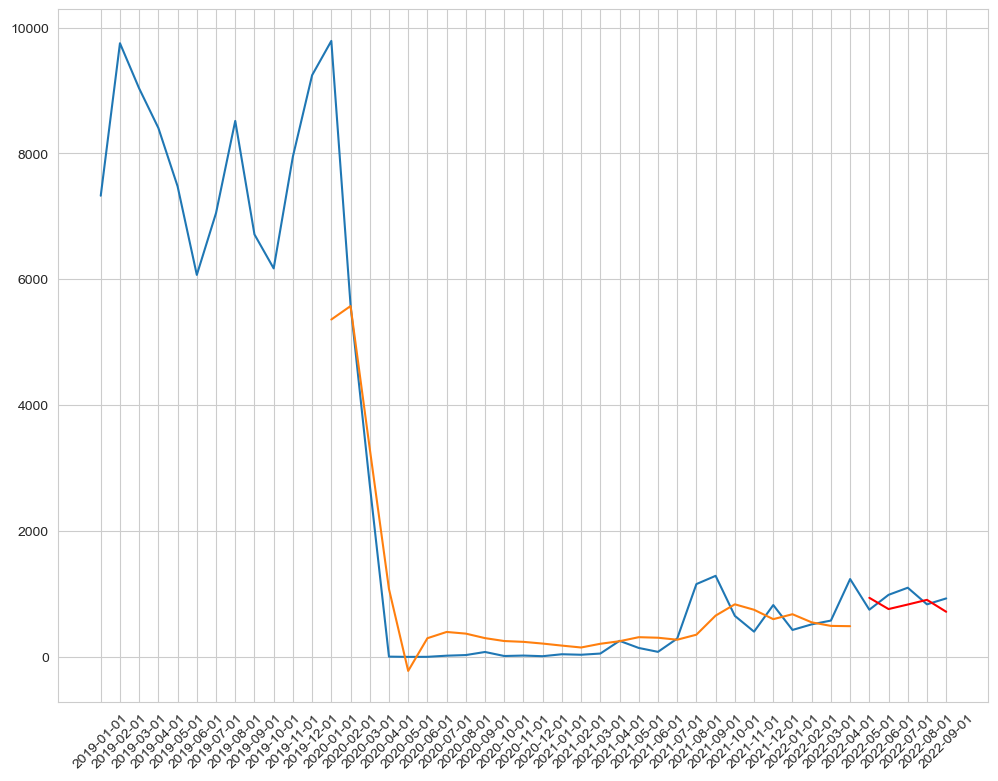

In [18]:
fig, ax = plt.subplots(figsize=(12,9))
sns.set_style("whitegrid")
ax.plot(palau["date"].values, palau["total"].values)
ax.plot(y_train_df["date"].values, y_train_df["total"].values)
ax.plot(y_pred_df["date"].values, y_pred_df["total"].values, color="red")
plt.xticks(rotation=45)
plt.show()